In [1]:
import pandas as pd
from matplotlib.offsetbox import (OffsetImage,AnnotationBbox)
import matplotlib.pyplot as plt
from mplsoccer import FontManager, add_image
from PIL import Image
import numpy as np
import os 
import difflib

In [6]:
pagina = pd.read_html("https://fbref.com/es/equipos/b8fd03ef/2022-2023/all_comps/Estadisticas-de-Manchester-City-Todas-las-competencias")

In [7]:
len(pagina)

67

In [8]:
df = pagina[0]
df.columns = ["_".join(col) if 'Unnamed' not in col[0] else col[1] for col in df.columns.values]
df.columns

Index(['Jugador', 'País', 'Posc', 'Edad', 'Tiempo Jugado_PJ',
       'Tiempo Jugado_Titular', 'Tiempo Jugado_Mín', 'Tiempo Jugado_90 s',
       'Rendimiento_Gls.', 'Rendimiento_Ass', 'Rendimiento_G+A',
       'Rendimiento_G-TP', 'Rendimiento_TP', 'Rendimiento_TPint',
       'Rendimiento_TA', 'Rendimiento_TR', 'Expectativa_xG',
       'Expectativa_npxG', 'Expectativa_xAG', 'Expectativa_npxG+xAG',
       'Progresión_PrgC', 'Progresión_PrgP', 'Progresión_PrgR',
       'Por 90 Minutos_Gls.', 'Por 90 Minutos_Ast', 'Por 90 Minutos_G+A',
       'Por 90 Minutos_G-TP', 'Por 90 Minutos_G+A-TP', 'Por 90 Minutos_xG',
       'Por 90 Minutos_xAG', 'Por 90 Minutos_xG+xAG', 'Por 90 Minutos_npxG',
       'Por 90 Minutos_npxG+xAG', 'Partidos'],
      dtype='object')

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def plot_stats(df, stat_x, stat_y, title, xlabel, ylabel, files_filtrados, zoom_min=0.1, zoom_max=0.35):
    """
    Plotea estadísticas de los jugadores en un gráfico scatter con imágenes.
    
    Parámetros:
    - df: DataFrame que contiene los datos de los jugadores.
    - stat_x: Nombre de la columna que será usada para el eje X.
    - stat_y: Nombre de la columna que será usada para el eje Y.
    - title: Título del gráfico.
    - xlabel: Nombre para el eje X.
    - ylabel: Nombre para el eje Y.
    - files_filtrados: Lista de rutas a las imágenes de los jugadores.
    - zoom_min: Zoom mínimo para las imágenes de los jugadores.
    - zoom_max: Zoom máximo para las imágenes de los jugadores.
    """
    
    # Extraer los datos para el eje X e Y
    x, promx = df[stat_x], df[stat_x].mean()
    y, promy = df[stat_y], df[stat_y].mean()

    # Configuración del gráfico
    facecolor = '#87CEEB'
    color_plot = 'white'

    fig, ax = plt.subplots(figsize=(20, 12))
    ax.scatter(x, y)

    # Establecemos los mismos límites para ambos ejes
    ax.set_xlim(0, max(x.max(), y.max()))
    ax.set_ylim(0, max(x.max(), y.max()))

    # Detalles estéticos
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_color(color_plot)
    ax.spines['left'].set_color(color_plot)
    for axis in ['top', 'bottom', 'left', 'right']:
        ax.spines[axis].set_linewidth(1.5)
    ax.yaxis.set_tick_params(pad=12, colors=color_plot, labelsize=12)
    ax.xaxis.set_tick_params(pad=12, colors=color_plot, labelsize=12)

    fig.patch.set_facecolor(facecolor)
    ax.set_facecolor(facecolor)

    # Líneas de promedio
    ax.axvline(promx, color=color_plot)
    ax.axhline(promy, color=color_plot)

    # Nombres de los ejes y título
    ax.set_xlabel(xlabel, fontsize=18, color=color_plot)
    ax.set_ylabel(ylabel, fontsize=18, color=color_plot)
    ax.set_title(f'{xlabel} vs {ylabel} - {title}', loc='left', color=color_plot, fontsize=25, fontweight="bold", pad=20)

    # Función para cargar las imágenes de los jugadores
    def getImage(path, zoom=0.17):
        return OffsetImage(plt.imread(path), zoom=zoom)

    # Función para ajustar el zoom según las posiciones de x e y
    def calcular_zoom(x, y, x_min, x_max, y_min, y_max, zoom_min, zoom_max):
        x_norm = (np.log1p(x - x_min)) / (np.log1p(x_max - x_min))
        y_norm = (np.log1p(y - y_min)) / (np.log1p(y_max - y_min))
        zoom = zoom_min + (x_norm + y_norm) / 2 * (zoom_max - zoom_min)
        return zoom

    # Encontrar los valores mínimo y máximo
    x_min, x_max = x.min(), x.max()
    y_min, y_max = y.min(), y.max()

    # Función para evitar el solapamiento
    def ajustar_solapamiento(x0, y0, puntos_existentes, min_distancia=1.0):
        for (xp, yp) in puntos_existentes:
            distancia = np.sqrt((x0 - xp)**2 + (y0 - yp)**2)
            if distancia < min_distancia:
                x0 += min_distancia * (x0 - xp) / distancia
                y0 += min_distancia * (y0 - yp) / distancia
        return x0, y0

    # Lista para almacenar las posiciones de los puntos
    puntos_existentes = []

    # Escudos con ajuste de posición para evitar solapamientos
    for x0, y0, file in zip(x, y, files_filtrados):
        zoom = calcular_zoom(x0, y0, x_min, x_max, y_min, y_max, zoom_min, zoom_max)
        x0_mod, y0_mod = ajustar_solapamiento(x0, y0, puntos_existentes, min_distancia=1.0)
        puntos_existentes.append((x0_mod, y0_mod))
        ab = AnnotationBbox(getImage(f'players/{file}', zoom=zoom), (x0_mod, y0_mod), frameon=False)
        ax.add_artist(ab)

    plt.show()


In [35]:
df_plot = df[['Jugador','Rendimiento_Gls.','Expectativa_xG']]
df_plot = df_plot.iloc[:-2]
df_plot = df_plot[(df_plot['Rendimiento_Gls.'] != 0) | (df_plot['Expectativa_xG'] != 0)]
df_plot = df_plot.sort_values(by="Rendimiento_Gls.",ascending=False)
df_plot = df_plot.iloc[:16]
df_plot = df_plot.sort_values(by="Jugador")
df_plot = df_plot.dropna()

df_plot

,Jugador,Rendimiento_Gls.,Expectativa_xG
6,Bernardo Silva,7.0,3.3
20,Cole Palmer,1.0,1.5
2,Erling Haaland,52.0,39.0
7,Jack Grealish,5.0,5.6
12,John Stones,3.0,1.1
15,João Cancelo,2.0,1.1
14,Julián Álvarez,17.0,9.4
5,Kevin De Bruyne,10.0,6.8
4,Manuel Akanji,1.0,2.2
10,Nathan Aké,3.0,1.7


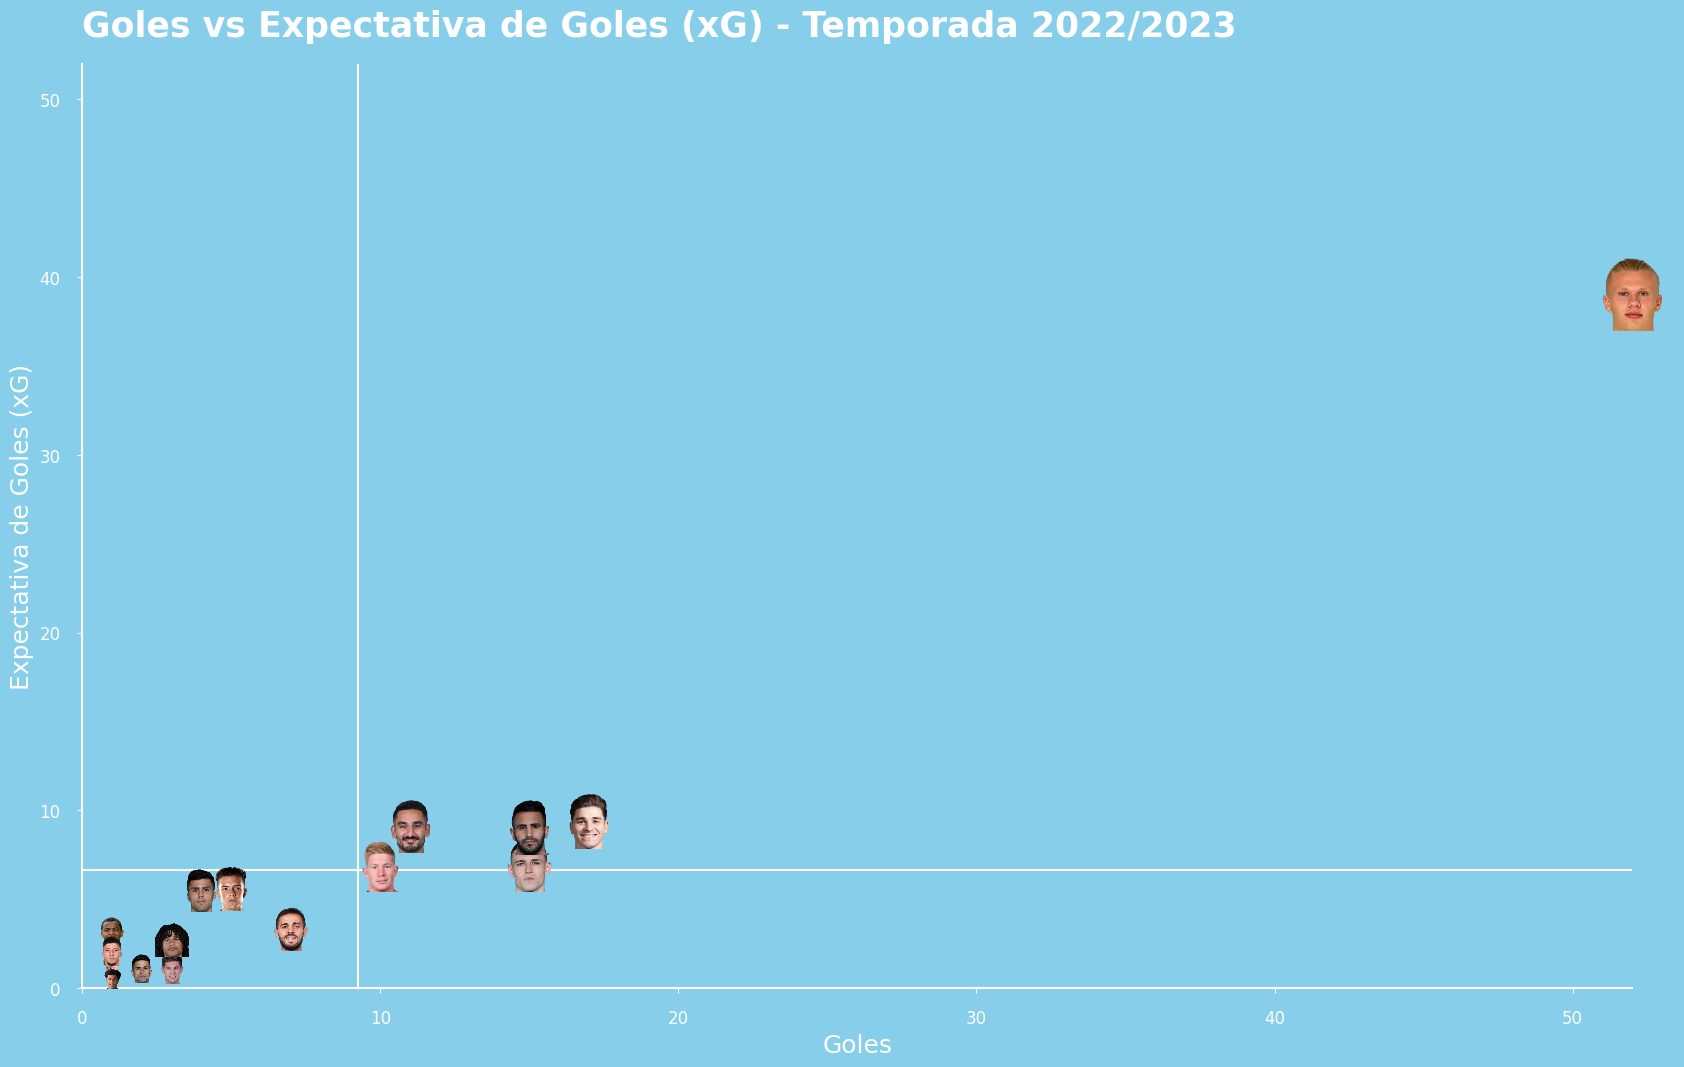

In [36]:
def encontrar_archivo_mas_parecido(jugador, files, threshold=0.6):
    posibles = difflib.get_close_matches(jugador, files, n=1, cutoff=threshold)
    return posibles[0] if posibles else None

# Obtener la lista de archivos en la carpeta 'players'
path = os.getcwd()
files = os.listdir('players')

# Filtrar los jugadores del DataFrame
jugadores_filtrados = df_plot["Jugador"].tolist()
files_filtrados = []

# Recorremos los jugadores y buscamos archivos similares
for jugador in jugadores_filtrados:
    jugador_normalizado = jugador.lower().replace(" ", "_")
    archivo_similar = encontrar_archivo_mas_parecido(jugador_normalizado, files)
    if archivo_similar:
        files_filtrados.append(archivo_similar)

# Ahora que ya tenemos la lista `files_filtrados`, puedes proceder a llamar a la función de ploteo
plot_stats(
    df=df_plot,
    stat_x="Rendimiento_Gls.",
    stat_y="Expectativa_xG",
    title="Temporada 2022/2023",
    xlabel="Goles",
    ylabel="Expectativa de Goles (xG)",
    files_filtrados=files_filtrados  # Lista de rutas de imágenes de jugadores
)

In [37]:
df_plot = df[['Jugador','Rendimiento_Ass','Expectativa_xAG']]
df_plot = df_plot.iloc[:-2]
df_plot = df_plot[(df_plot['Rendimiento_Ass'] != 0) | (df_plot['Expectativa_xAG'] != 0)]
df_plot = df_plot.sort_values(by="Rendimiento_Ass",ascending=False)
df_plot = df_plot[:16]
df_plot = df_plot.sort_values(by="Jugador")
df_plot = df_plot.dropna()

df_plot

,Jugador,Rendimiento_Ass,Expectativa_xAG
6,Bernardo Silva,6.0,4.6
20,Cole Palmer,1.0,0.6
1,Ederson,1.0,0.2
2,Erling Haaland,9.0,6.1
7,Jack Grealish,11.0,10.0
12,John Stones,3.0,2.1
15,João Cancelo,5.0,1.9
14,Julián Álvarez,4.0,2.8
5,Kevin De Bruyne,28.0,17.2
11,Kyle Walker,1.0,0.4


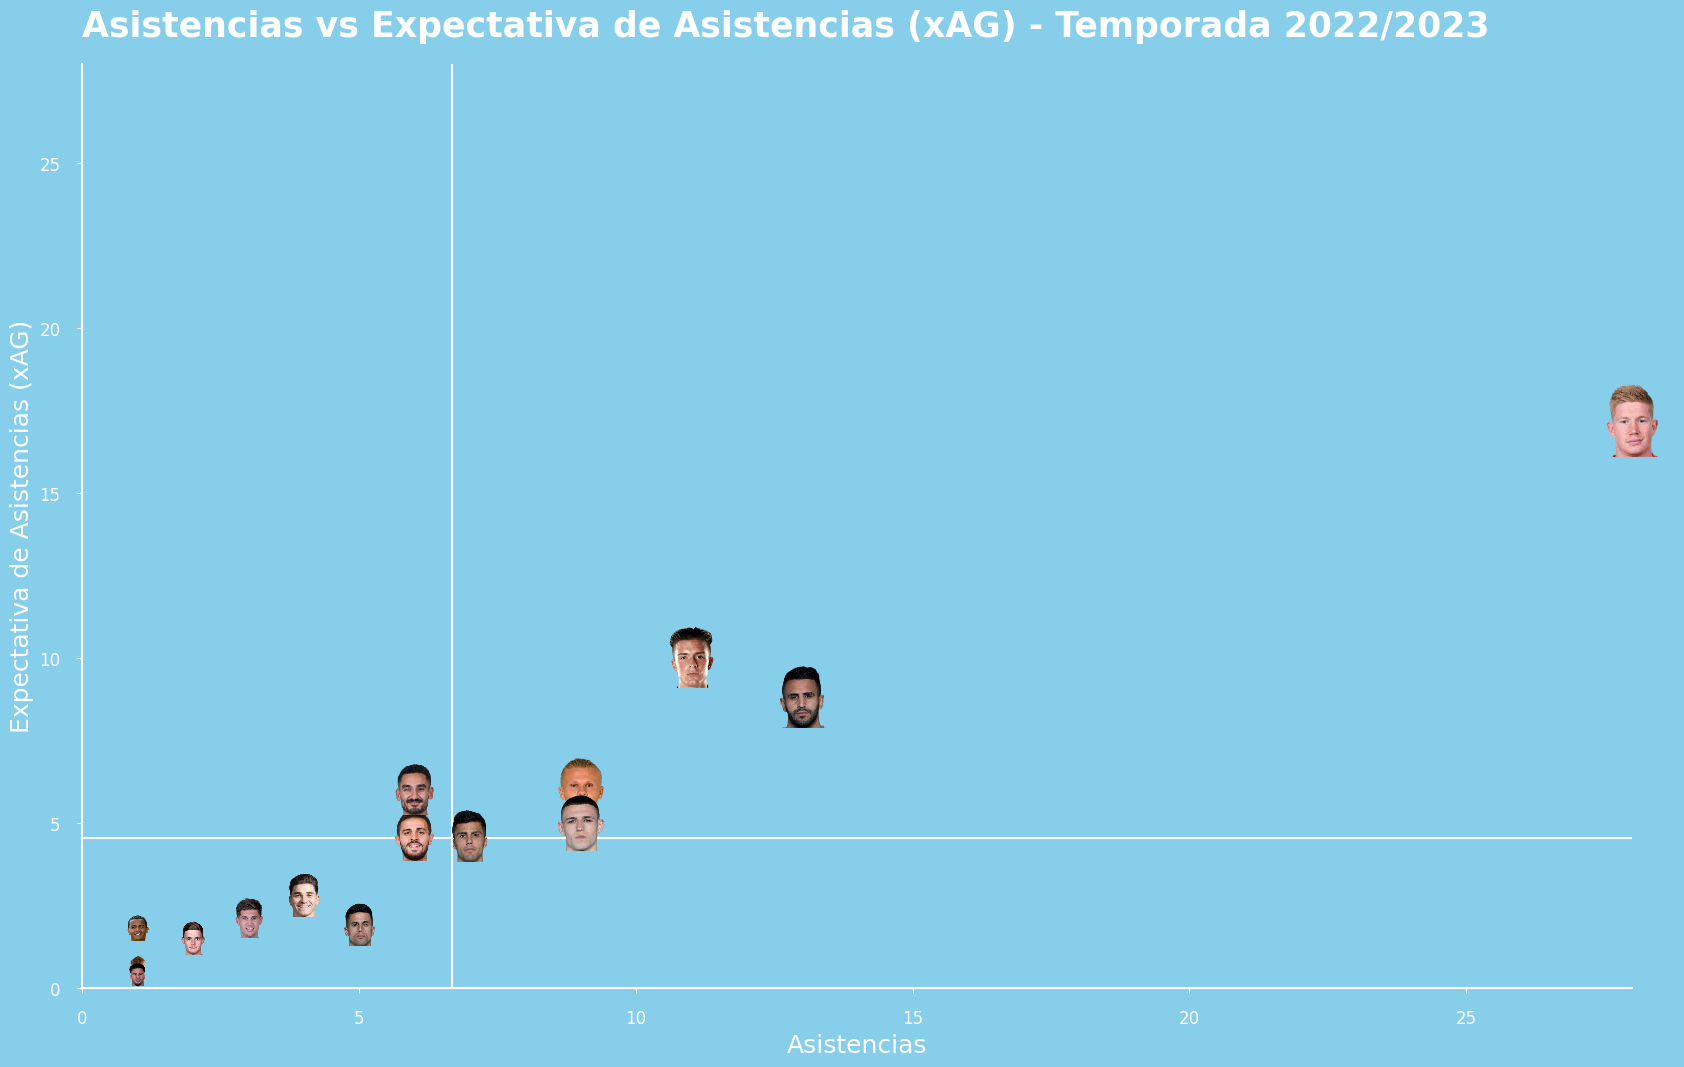

In [38]:
# Filtrar los jugadores del DataFrame
jugadores_filtrados = df_plot["Jugador"].tolist()
files_filtrados = []

# Recorremos los jugadores y buscamos archivos similares
for jugador in jugadores_filtrados:
    jugador_normalizado = jugador.lower().replace(" ", "_")
    archivo_similar = encontrar_archivo_mas_parecido(jugador_normalizado, files)
    if archivo_similar:
        files_filtrados.append(archivo_similar)

plot_stats(
    df=df_plot,
    stat_x="Rendimiento_Ass",
    stat_y="Expectativa_xAG",
    title="Temporada 2022/2023",
    xlabel="Asistencias",
    ylabel="Expectativa de Asistencias (xAG)",
    files_filtrados=files_filtrados  # Lista de rutas de imágenes de jugadores
)


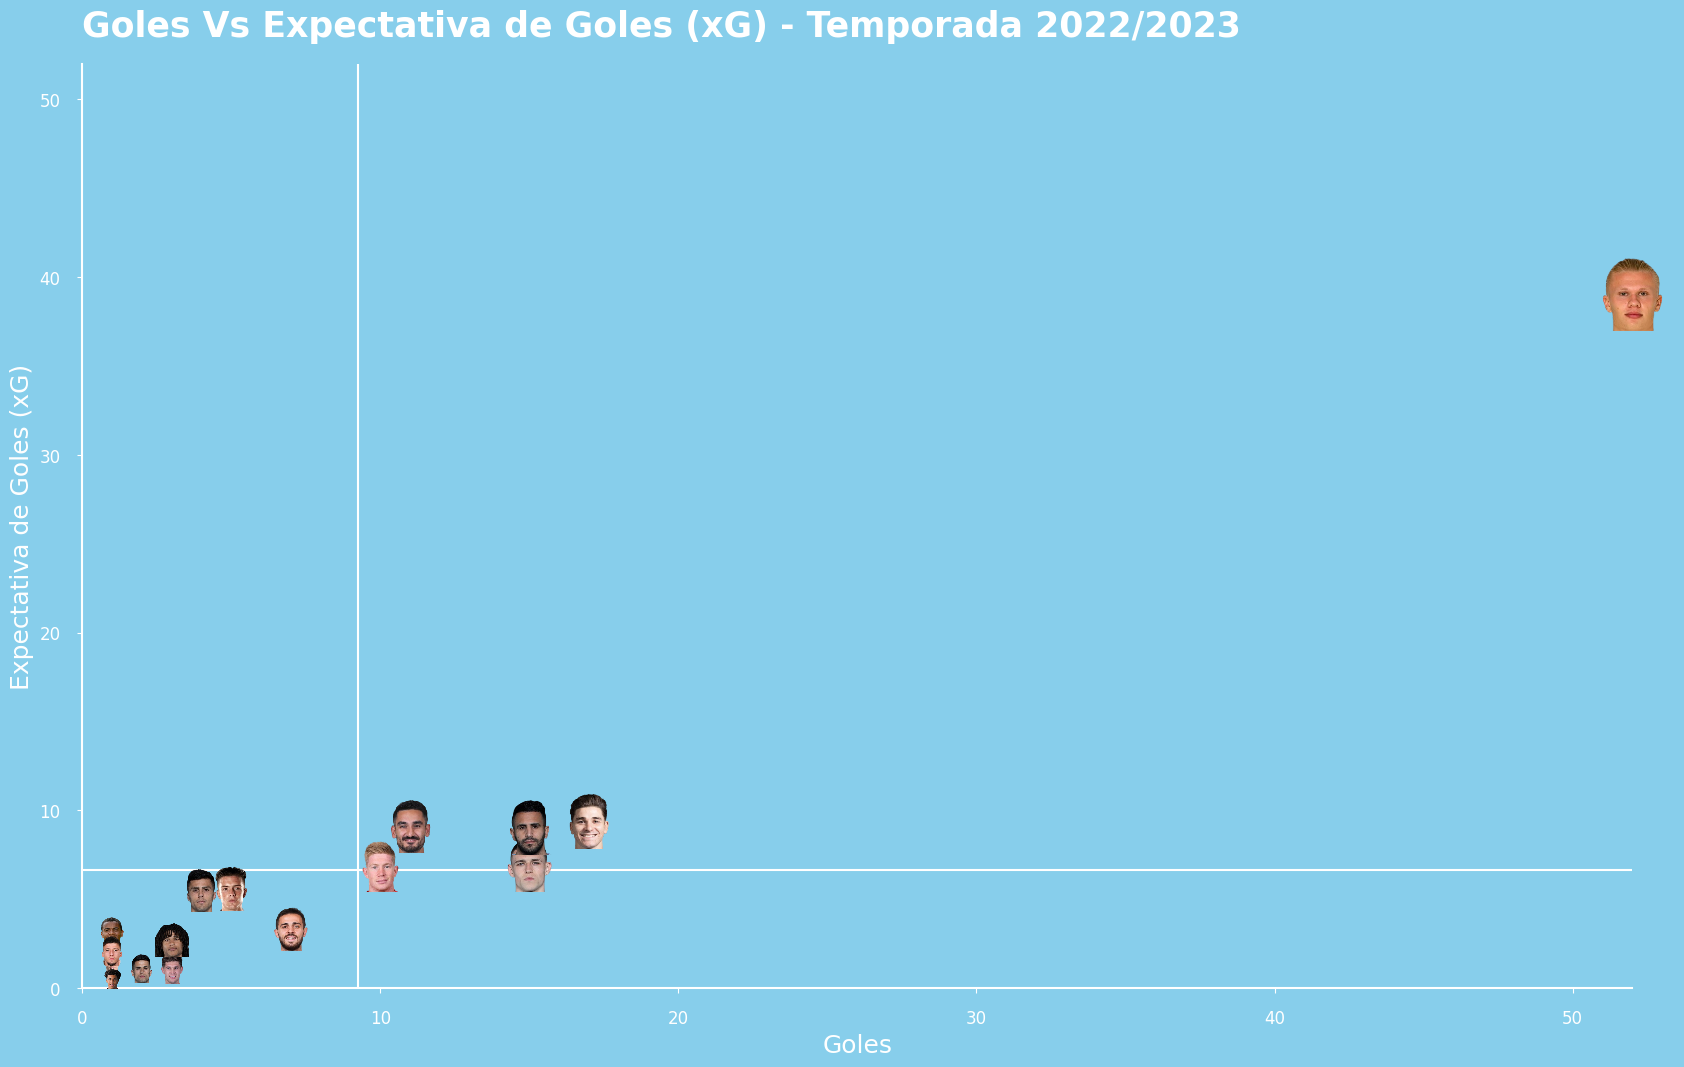

In [40]:
plot_stats(
    df=df_plot,
    stat_x="Rendimiento_Gls.",
    stat_y="Expectativa_xG",
    title="Temporada 2022/2023",
    xlabel="Goles",
    ylabel="Expectativa de Goles (xG)",
    files_filtrados=files_filtrados  # Lista de rutas de imágenes de jugadores
)


In [9]:
pagina[4].head()

Unnamed: 0_level_0 Unnamed: 1_level_0 Unnamed: 2_level_0 Unnamed: 3_level_0  \
             Jugador               País               Posc               Edad   
0            Ederson             br BRA                 PO               28.0   
1              Rodri             es ESP                 CC               26.0   
2     Erling Haaland             no NOR                 DL               22.0   
3    Kevin De Bruyne             be BEL                 CC               31.0   
4     İlkay Gündoğan             de GER                 CC               31.0   

  Unnamed: 4_level_0 Estándar                         ...                    \
                90 s     Gls.  Dis DaP % de TT  T/90  ...  Dist FK TP TPint   
0               35.0        0    0   0     NaN  0.00  ...   NaN  0  0     0   
1               32.3        2   50  14    28.0  1.55  ...  17.1  0  0     0   
2               30.8       36  116  53    45.7  3.77  ...  12.6  0  7     7   
3               26.9        7   65  21    32.3  2.42  ...  23.0  7  0     0   
4               26.1        8   53  20    37.7  2.03  ...  18.1  5  0     1   

  Expectativa                            Unnamed: 22_level_0  
           xG  npxG npxG/Sh G-xG np:G-xG            Partidos  
0         0.0   0.0     NaN  0.0     0.0            Partidos  
1         4.6   4.6    0.09 -2.6    -2.6            Partidos  
2        28.4  23.0    0.20  7.6     6.0            Partidos  
3         5.6   5.6    0.09  1.4     1.4            Partidos  
4         7.5   6.7    0.13  0.5     1.3            Partidos  

[5 rows x 23 columns]

In [10]:
pagina[5].head()

Unnamed: 0_level_0 Unnamed: 1_level_0 Unnamed: 2_level_0 Unnamed: 3_level_0  \
             Jugador               País               Posc               Edad   
0            Ederson             br BRA                 PO               28.0   
1              Rodri             es ESP                 CC               26.0   
2     Erling Haaland             no NOR                 DL               22.0   
3    Kevin De Bruyne             be BEL                 CC               31.0   
4     İlkay Gündoğan             de GER                 CC               31.0   

  Unnamed: 4_level_0 Total                                    ...  \
                90 s   Cmp  Int. % Cmp Dist. tot. Dist. prg.  ...   
0               35.0  1079  1257  85.8      26248      17275  ...   
1               32.3  2723  2987  91.2      49949      11936  ...   
2               30.8   360   500  72.0       4403        947  ...   
3               26.9  1192  1626  73.3      22165       6516  ...   
4               26.1  1374  1578  87.1      21396       4941  ...   

  Unnamed: 19_level_0 Unnamed: 20_level_0 Expectativa        \
                  Ass                 xAG          xA A-xAG   
0                   1                 0.2         0.2   0.8   
1                   6                 4.1         3.5   1.9   
2                   8                 5.3         3.1   2.7   
3                  16                13.7        14.1   2.3   
4                   4                 3.3         4.4   0.7   

  Unnamed: 23_level_0 Unnamed: 24_level_0 Unnamed: 25_level_0  \
                   PC                 1/3                 PPA   
0                   1                  13                   0   
1                  32                 265                  33   
2                  29                  14                  23   
3                  96                 124                  96   
4                  37                 143                  35   

  Unnamed: 26_level_0 Unnamed: 27_level_0 Unnamed: 28_level_0  
                 CrAP                PrgP            Partidos  
0                   0                   0            Partidos  
1                   3                 260            Partidos  
2                   0                  58            Partidos  
3                  21                 246            Partidos  
4                   1                 170            Partidos  

[5 rows x 29 columns]

In [11]:
pagina[6].head()

Unnamed: 0_level_0 Unnamed: 1_level_0 Unnamed: 2_level_0 Unnamed: 3_level_0  \
             Jugador               País               Posc               Edad   
0            Ederson             br BRA                 PO               28.0   
1              Rodri             es ESP                 CC               26.0   
2     Erling Haaland             no NOR                 DL               22.0   
3    Kevin De Bruyne             be BEL                 CC               31.0   
4     İlkay Gündoğan             de GER                 CC               31.0   

  Unnamed: 4_level_0 Unnamed: 5_level_0 Tipos de pases                       \
                90 s               Int.     Balón vivo Balón muerto  FK  PL   
0               35.0               1257           1049          207  55   1   
1               32.3               2987           2943           43  37   2   
2               30.8                500            449           45   0   4   
3               26.9               1626           1454          160  53  28   
4               26.1               1578           1519           56  24  18   

   ...                Saques de esquina             Resultados               \
   ...  Pcz Lanz.  SE            Dentro Fuera Rect.        Cmp  PA Bloqueos   
0  ...    0     0   0                 0     0     0       1079   1        1   
1  ...    6     3   0                 0     0     0       2723   1       21   
2  ...   12     2   1                 0     0     0        360   6       21   
3  ...  226    31  72                20    32     6       1192  12       41   
4  ...   30     5  21                 7     4     1       1374   3       27   

  Unnamed: 20_level_0  
             Partidos  
0            Partidos  
1            Partidos  
2            Partidos  
3            Partidos  
4            Partidos  

[5 rows x 21 columns]

In [12]:
pagina[7].head()

Unnamed: 0_level_0 Unnamed: 1_level_0 Unnamed: 2_level_0 Unnamed: 3_level_0  \
             Jugador               País               Posc               Edad   
0            Ederson             br BRA                 PO               28.0   
1              Rodri             es ESP                 CC               26.0   
2     Erling Haaland             no NOR                 DL               22.0   
3    Kevin De Bruyne             be BEL                 CC               31.0   
4     İlkay Gündoğan             de GER                 CC               31.0   

  Unnamed: 4_level_0  ACT       Tipos de SCA                 ...     ACG  \
                90 s  ACT SCA90     PassLive PassDead HASTA  ... Def ACG   
0               35.0    2  0.06            2        0     0  ...   0   1   
1               32.3   92  2.84           80        0     4  ...   1  10   
2               30.8   72  2.34           48        0     5  ...   1  17   
3               26.9  176  6.55          120       33     8  ...   3  31   
4               26.1   90  3.44           71        7     2  ...   2  17   

        Tipos de GCA                           Unnamed: 21_level_0  
  GCA90     PassLive PassDead HASTA Dis FR Def            Partidos  
0  0.03            1        0     0   0  0   0            Partidos  
1  0.31           10        0     0   0  0   0            Partidos  
2  0.55           14        0     0   1  2   0            Partidos  
3  1.15           24        3     1   1  2   0            Partidos  
4  0.65           13        1     0   1  2   0            Partidos  

[5 rows x 22 columns]

In [13]:
pagina[8].head()

Unnamed: 0_level_0 Unnamed: 1_level_0 Unnamed: 2_level_0 Unnamed: 3_level_0  \
             Jugador               País               Posc               Edad   
0            Ederson             br BRA                 PO               28.0   
1              Rodri             es ESP                 CC               26.0   
2     Erling Haaland             no NOR                 DL               22.0   
3    Kevin De Bruyne             be BEL                 CC               31.0   
4     İlkay Gündoğan             de GER                 CC               31.0   

  Unnamed: 4_level_0 Derribos                                    ... Desafíos  \
                90 s      Tkl TklG 3.º def. 3.º cent. 3.º ataq.  ...     Tkl%   
0               35.0        3    1        3         0         0  ...     50.0   
1               32.3       67   41       28        28        11  ...     49.1   
2               30.8        3    2        0         2         1  ...     20.0   
3               26.9       28   12        3        12        13  ...     35.9   
4               26.1       30   18        7        13        10  ...     35.3   

          Bloqueos           Unnamed: 17_level_0 Unnamed: 18_level_0  \
  Pérdida Bloqueos Dis Pases                 Int             Tkl+Int   
0       1        0   0     0                   1                   4   
1      27       40  14    26                  33                 100   
2       4       12   4     8                   3                   6   
3      25       27   2    25                   9                  37   
4      22       18   3    15                  20                  50   

  Unnamed: 19_level_0 Unnamed: 20_level_0 Unnamed: 21_level_0  
                Desp.                 Err            Partidos  
0                  10                   2            Partidos  
1                  43                   1            Partidos  
2                  14                   0            Partidos  
3                  10                   0            Partidos  
4                  13                   0            Partidos  

[5 rows x 22 columns]

In [14]:
pagina[9].head()

Unnamed: 0_level_0 Unnamed: 1_level_0 Unnamed: 2_level_0 Unnamed: 3_level_0  \
             Jugador               País               Posc               Edad   
0            Ederson             br BRA                 PO               28.0   
1              Rodri             es ESP                 CC               26.0   
2     Erling Haaland             no NOR                 DL               22.0   
3    Kevin De Bruyne             be BEL                 CC               31.0   
4     İlkay Gündoğan             de GER                 CC               31.0   

  Unnamed: 4_level_0 Toques                                         ...  \
                90 s Toques Def. pen. 3.º def. 3.º cent. 3.º ataq.  ...   
0               35.0   1302      1049     1295         9         0  ...   
1               32.3   3272       119      706      1993       592  ...   
2               30.8    763        18       39       290       435  ...   
3               26.9   1860        13      100       743      1041  ...   
4               26.1   1806        31      243       975       596  ...   

  Transportes                                                Recepción       \
   Dist. tot. Dist. prg. PrgC 1/3 TAP Errores de control Des       Rec PrgR   
0        4059       2429    0   0   0                  0   0       833    0   
1       10293       5622   76  72   3                 21  19      2511   37   
2        2020        761   35  10  25                 51  26       583  151   
3        5721       3415  100  81  16                 42  29      1445  245   
4        5457       2628   53  44   7                 28  27      1425  124   

  Unnamed: 27_level_0  
             Partidos  
0            Partidos  
1            Partidos  
2            Partidos  
3            Partidos  
4            Partidos  

[5 rows x 28 columns]

In [15]:
pagina[9].head()

Unnamed: 0_level_0 Unnamed: 1_level_0 Unnamed: 2_level_0 Unnamed: 3_level_0  \
             Jugador               País               Posc               Edad   
0            Ederson             br BRA                 PO               28.0   
1              Rodri             es ESP                 CC               26.0   
2     Erling Haaland             no NOR                 DL               22.0   
3    Kevin De Bruyne             be BEL                 CC               31.0   
4     İlkay Gündoğan             de GER                 CC               31.0   

  Unnamed: 4_level_0 Toques                                         ...  \
                90 s Toques Def. pen. 3.º def. 3.º cent. 3.º ataq.  ...   
0               35.0   1302      1049     1295         9         0  ...   
1               32.3   3272       119      706      1993       592  ...   
2               30.8    763        18       39       290       435  ...   
3               26.9   1860        13      100       743      1041  ...   
4               26.1   1806        31      243       975       596  ...   

  Transportes                                                Recepción       \
   Dist. tot. Dist. prg. PrgC 1/3 TAP Errores de control Des       Rec PrgR   
0        4059       2429    0   0   0                  0   0       833    0   
1       10293       5622   76  72   3                 21  19      2511   37   
2        2020        761   35  10  25                 51  26       583  151   
3        5721       3415  100  81  16                 42  29      1445  245   
4        5457       2628   53  44   7                 28  27      1425  124   

  Unnamed: 27_level_0  
             Partidos  
0            Partidos  
1            Partidos  
2            Partidos  
3            Partidos  
4            Partidos  

[5 rows x 28 columns]

In [16]:
pagina[10].head()

Unnamed: 0_level_0 Unnamed: 1_level_0 Unnamed: 2_level_0 Unnamed: 3_level_0  \
             Jugador               País               Posc               Edad   
0            Ederson             br BRA                 PO               28.0   
1              Rodri             es ESP                 CC               26.0   
2     Erling Haaland             no NOR                 DL               22.0   
3    Kevin De Bruyne             be BEL                 CC               31.0   
4     İlkay Gündoğan             de GER                 CC               31.0   

  Unnamed: 4_level_0 Tiempo Jugado                   Titular  ...  \
                  PJ           Mín Mn/PJ % min  90 s Titular  ...   
0                 35        3150.0  90.0  92.1  35.0      35  ...   
1                 36        2911.0  81.0  85.1  32.3      34  ...   
2                 35        2769.0  79.0  81.0  30.8      33  ...   
3                 32        2417.0  76.0  70.7  26.9      28  ...   
4                 31        2353.0  76.0  68.8  26.1      27  ...   

  Logros del equipo                          Logros del equipo (xG)        \
               onGA   +/- +/-90 Dentro-Fuera                   onxG onxGA   
0              32.0  57.0  1.63         0.30                   73.3  28.3   
1              26.0  57.0  1.76         1.06                   67.4  24.4   
2              26.0  58.0  1.89         1.47                   66.9  24.3   
3              23.0  46.0  1.71         0.37                   58.7  19.4   
4              20.0  51.0  1.95         1.11                   61.3  19.4   

                             Unnamed: 26_level_0  
  xG+/- xG+/-90 Dentro-Fuera            Partidos  
0  45.1    1.29         0.81            Partidos  
1  43.0    1.33         0.71            Partidos  
2  42.6    1.38         0.84            Partidos  
3  39.2    1.46         0.81            Partidos  
4  41.9    1.60         1.21            Partidos  

[5 rows x 27 columns]

In [17]:
pagina[11].head()

Unnamed: 0_level_0 Unnamed: 1_level_0 Unnamed: 2_level_0 Unnamed: 3_level_0  \
             Jugador               País               Posc               Edad   
0            Ederson             br BRA                 PO               28.0   
1              Rodri             es ESP                 CC               26.0   
2     Erling Haaland             no NOR                 DL               22.0   
3    Kevin De Bruyne             be BEL                 CC               31.0   
4     İlkay Gündoğan             de GER                 CC               31.0   

  Unnamed: 4_level_0 Rendimiento                         ...           \
                90 s          TA TR 2a amarilla Fls  FR  ... Int TklG   
0               35.0           3  0           0   1   4  ...   1    1   
1               32.3           5  0           0  47  20  ...  33   41   
2               30.8           5  0           0  31  24  ...   3    2   
3               26.9           1  0           0  20  29  ...   9   12   
4               26.1           0  0           0  23  25  ...  20   18   

                                            Duelos aéreos           \
  Penal ejecutado Penal concedido GC Recup.       Ganados Perdidos   
0               0               1  0     35             8        1   
1               0               0  0    301            72       32   
2               1               0  0     37            50       50   
3               2               0  0     97            13       13   
4               2               0  0    155            19       12   

               Unnamed: 21_level_0  
  % de ganados            Partidos  
0         88.9            Partidos  
1         69.2            Partidos  
2         50.0            Partidos  
3         50.0            Partidos  
4         61.3            Partidos  

[5 rows x 22 columns]

In [18]:
pagina[12].head()

,RL,Equipo,PJ,PG,PE,PP,GF,GC,DG,Pts,Pts/PJ,xG,xGA,xGD,xGD/90,Asistencia,Máximo Goleador del Equipo,Portero,Notas
0,1,Manchester City,38,28,5,5,94,33,61,89,2.34,78.6,32.1,46.5,1.22,53249,Erling Haaland - 36,Ederson,→ Champions League Por el final de liga
1,2,Arsenal,38,26,6,6,88,43,45,84,2.21,71.6,42.0,29.6,0.78,60191,"Martin Ødegaard, Gabriel Martinelli - 15",Aaron Ramsdale,→ Champions League Por el final de liga
2,3,Manchester Utd,38,23,6,9,58,43,15,75,1.97,67.7,50.4,17.3,0.45,73671,Marcus Rashford - 17,David de Gea,→ Champions League Por el final de liga


In [19]:
pagina[13].head()

Unnamed: 0_level_0 Unnamed: 1_level_0 Local                            ...  \
                  RL             Equipo    PJ  PG PE PP  GF  GC  DG Pts  ...   
0                  1    Manchester City    19  17  1  1  60  17  43  52  ...   
1                  2            Arsenal    19  14  3  2  53  25  28  45  ...   
2                  3     Manchester Utd    19  15  3  1  36  10  26  48  ...   

  Visitante                                                  
         PP  GF  GC  DG Pts Pts/PJ    xG   xGA   xGD xGD/90  
0         4  34  16  18  37   1.95  35.9  19.3  16.6   0.87  
1         4  35  18  17  39   2.05  29.1  22.7   6.4   0.34  
2         8  22  33 -11  27   1.42  26.7  31.0  -4.3  -0.22  

[3 rows x 28 columns]